In [3]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import rioxarray as rxr
import cartopy.crs as ccrs

In [4]:
ESM5_data = xr.open_dataset("../data/CanESM5_ssp_tas.nc", engine="netcdf4")

<xarray.Dataset> Size: 846MB
Dimensions:    (member: 25, time: 1032, bnds: 2, lat: 64, lon: 128)
Coordinates:
  * member     (member) int64 200B 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * time       (time) object 8kB 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lat        (lat) float64 512B -87.86 -85.1 -82.31 ... 82.31 85.1 87.86
  * lon        (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
    height     float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (member, time, bnds) object 413kB ...
    lat_bnds   (member, lat, bnds) float64 26kB ...
    lon_bnds   (member, lon, bnds) float64 51kB ...
    tas        (member, time, lat, lon) float32 845MB ...
Attributes: (12/53)
    CCCma_model_hash:            Unknown
    CCCma_parent_runid:          p2-his01
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 p2-s4501
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branc

C:\Users\Justin\AppData\Local\Temp\ipykernel_16392\3767702959.py:21: FutureWarning: In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
  da = da.assign_coords(time=da.indexes["time"].to_datetimeindex())
C:\Users\Justin\AppData\Local\Temp\ipykernel_16392\3767702959.py:21: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  da = da.assign_coords(time=da.indexes["time"].to_datetimeindex())


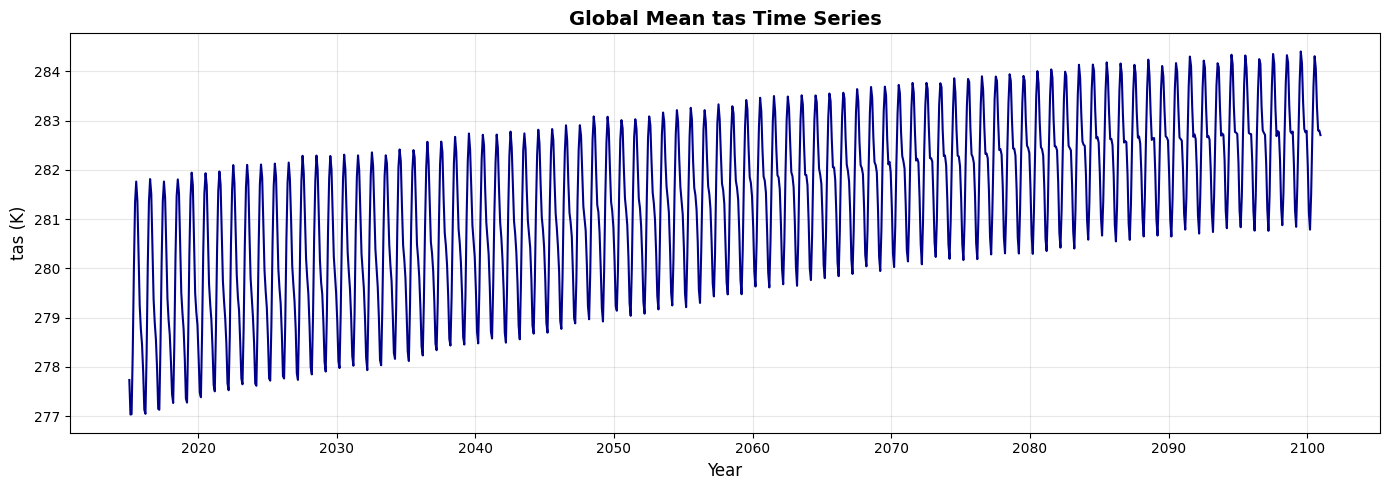

In [5]:
# Dataset overview
print(ESM5_data)
print("\nDimensions:", ESM5_data.dims)
print("Coordinates:", list(ESM5_data.coords))
print("Data variables:", list(ESM5_data.data_vars))

# Prefer the primary climate variable if present
if "tas" in ESM5_data.data_vars:
    var_name = "tas"
else:
    # Fall back to the first non-bounds variable
    non_bnds = [v for v in ESM5_data.data_vars if not v.endswith("_bnds")]
    var_name = non_bnds[0] if non_bnds else list(ESM5_data.data_vars)[0]
da = ESM5_data[var_name]
print("\nSelected variable:", var_name)
print(da)

# Convert time to pandas datetime if needed (avoid nc-time-axis requirement)
if "time" in da.coords:
    try:
        da = da.assign_coords(time=da.indexes["time"].to_datetimeindex())
    except Exception:
        pass

# Plot a spatial mean time series (if time exists)
if "time" in da.dims:
    spatial_dims = [d for d in da.dims if d != "time"]
    if spatial_dims:
        time_series = da.mean(spatial_dims)
        
        # Create a clear, professional-looking plot
        fig, ax = plt.subplots(figsize=(14, 5))
        time_series.plot(ax=ax, linewidth=1.5, color="darkblue")
        
        ax.set_xlabel("Year", fontsize=12)
        ax.set_ylabel(f"{var_name} (K)", fontsize=12)
        ax.set_title(f"Global Mean {var_name} Time Series", fontsize=14, fontweight="bold")
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

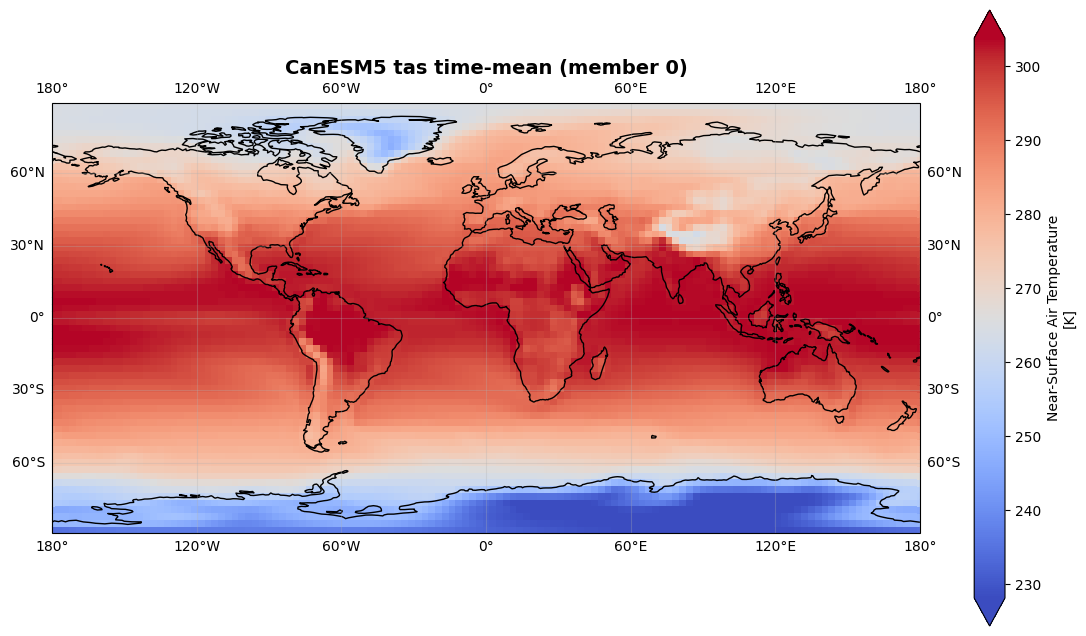

In [6]:
# Map of tas (time-mean, member 0)
map_da = ESM5_data["tas"]
if "time" in map_da.dims:
    map_da = map_da.mean("time")
if "member" in map_da.dims:
    map_da = map_da.isel(member=0)

fig = plt.figure(figsize=(14, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=1)
ax.gridlines(draw_labels=True, alpha=0.3)

map_da.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="coolwarm", robust=True, x="lon", y="lat")
plt.title("CanESM5 tas time-mean (member 0)", fontsize=14, fontweight="bold")
plt.show()

In [7]:
tas = ESM5_data["tas"]

lon = tas.lon
lat = tas.lat
min_lon = lon.min()
max_lon = lon.max()
min_lat = lat.min()
max_lat = lat.max()

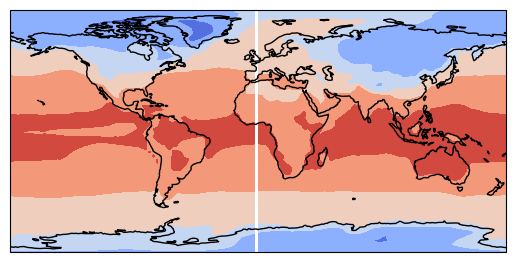

In [8]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.contourf(lon, lat, tas.isel(time=0, member=0), transform=ccrs.PlateCarree(), cmap="coolwarm")

<Figure size 1600x600 with 0 Axes>

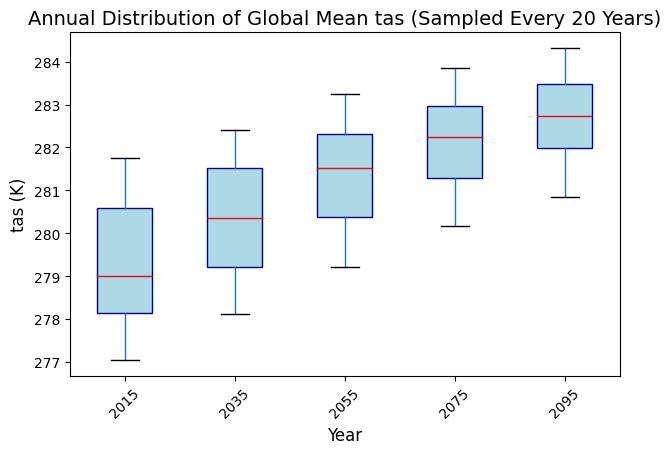

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Prepare the data: Get the spatial mean
spatial_dims = [d for d in da.dims if d != "time"]
time_series = da.mean(spatial_dims)

# 2. Convert to a Pandas DataFrame
df = time_series.to_dataframe(name=var_name)

# 3. Extract the year (Fixed for numpy.datetime64)
# Since 'time' is the index, we access it via df.index
df['year'] = pd.to_datetime(df.index).year

# 4. Filter years for the plot
sample_years = sorted(df['year'].unique())[::20] 
df_filtered = df[df['year'].isin(sample_years)]

# 5. Create the boxplot
plt.figure(figsize=(16, 6))
df_filtered.boxplot(column=var_name, by='year', grid=False, 
                    patch_artist=True, 
                    boxprops=dict(facecolor='lightblue', color='darkblue'),
                    medianprops=dict(color='red'))

plt.title(f"Annual Distribution of Global Mean {var_name} (Sampled Every 20 Years)", fontsize=14)
plt.suptitle("") 
plt.xlabel("Year", fontsize=12)
plt.ylabel(f"{var_name} (K)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()